In [1]:
import os
import twa
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

from twa.utils import ensure_dir, write_yaml
from twa.data.ode import FlowSystemODE
import random
from twa.train import VecTopoDataset, train_model, eval_model


random.seed(2)
torch.manual_seed(2)

torch.use_deterministic_algorithms(True) 
%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8


num_lattice = 64

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Classify point vs cycle attractor

### Train

In [2]:
# data
outdir = '../output/'
data_dir = os.path.join(outdir, 'data') 
dim = 2
batch_size = 64

num_all_classes = len(twa.dt.topo_num_to_str_dict)
num_classes = 2 

topo_idx = [twa.dt.topo_attr_spiral, twa.dt.topo_period_attr] 

train_data_descs = ['simple_oscillator_nsfcl']
train_data_desc_ = '_'.join(train_data_descs)

to_angle =  True 
with_attention = True 

save = False; save_dir = None
to_angle_str = 'angle' if to_angle else 'vector'
with_attention_str = 'atten' if with_attention else 'noatten'
exp_desc = train_data_desc_ + '_' + to_angle_str + '_' + with_attention_str 

datasize = 10000

11944


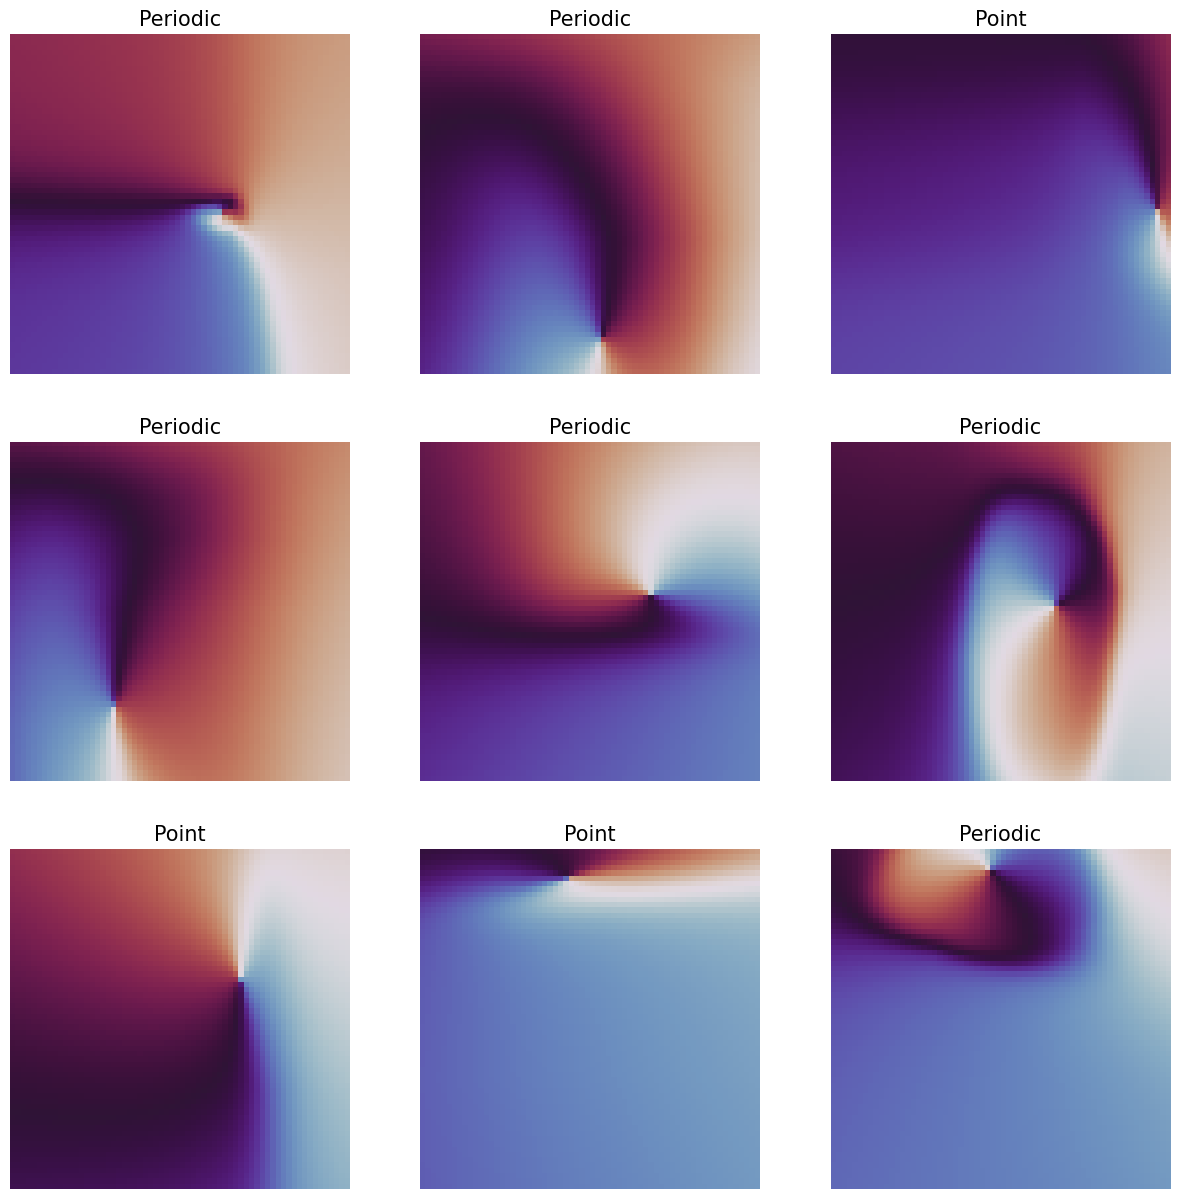

In [3]:

for itrain_data_desc, train_data_desc in enumerate(train_data_descs):
    train_data_dir = os.path.join(data_dir, train_data_desc)
    if itrain_data_desc == 0:
        train_dataset = VecTopoDataset(train_data_dir, to_angle=to_angle, datasize=datasize, filter_outbound=True)
        train_dataset.plot_data()
    else:
        train_dataset += VecTopoDataset(train_data_dir, to_angle=to_angle, datasize=datasize, filter_outbound=True)
        
 
    

In [5]:
# train
device = "cuda" if torch.cuda.is_available() else "cpu"

model, losses = train_model(train_dataset=train_dataset, verbose=True, to_angle=to_angle, with_attention=with_attention, num_lattice=num_lattice, latent_dim=2)

Training data size: 10000
Loading...
Training...
Train Epoch: 0 [0/10000 (0%)]	Loss: 0.693287
Train Epoch: 0 [128/10000 (0%)]	Loss: 0.693298
Train Epoch: 0 [256/10000 (0%)]	Loss: 0.693805
Train Epoch: 0 [384/10000 (0%)]	Loss: 0.693903
Train Epoch: 0 [512/10000 (0%)]	Loss: 0.693883
Train Epoch: 0 [640/10000 (0%)]	Loss: 0.693466
Train Epoch: 0 [768/10000 (0%)]	Loss: 0.692047
Train Epoch: 0 [896/10000 (0%)]	Loss: 0.692852
Train Epoch: 0 [1024/10000 (0%)]	Loss: 0.692156
Train Epoch: 0 [1152/10000 (0%)]	Loss: 0.693755
Train Epoch: 0 [1280/10000 (0%)]	Loss: 0.692658
Train Epoch: 0 [1408/10000 (0%)]	Loss: 0.691959
Train Epoch: 0 [1536/10000 (0%)]	Loss: 0.692869
Train Epoch: 0 [1664/10000 (0%)]	Loss: 0.690700
Train Epoch: 0 [1792/10000 (0%)]	Loss: 0.691089
Train Epoch: 0 [1920/10000 (0%)]	Loss: 0.694056
Train Epoch: 0 [2048/10000 (0%)]	Loss: 0.695118
Train Epoch: 0 [2176/10000 (0%)]	Loss: 0.693151
Train Epoch: 0 [2304/10000 (0%)]	Loss: 0.693227
Train Epoch: 0 [2432/10000 (0%)]	Loss: 0.696627
T

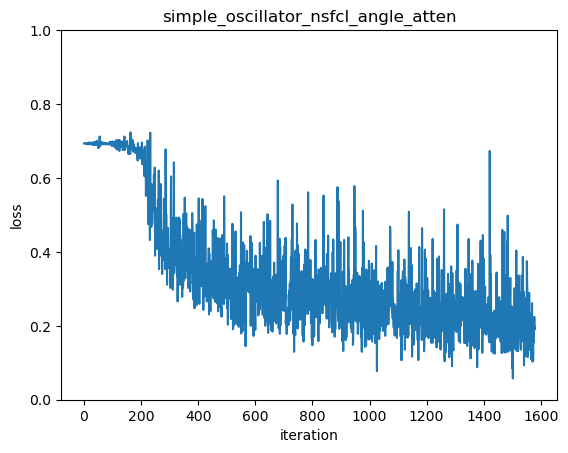

In [6]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title(exp_desc)
plt.ylim(0, 1)
plt.show()

torch.Size([10000]) (10000,)


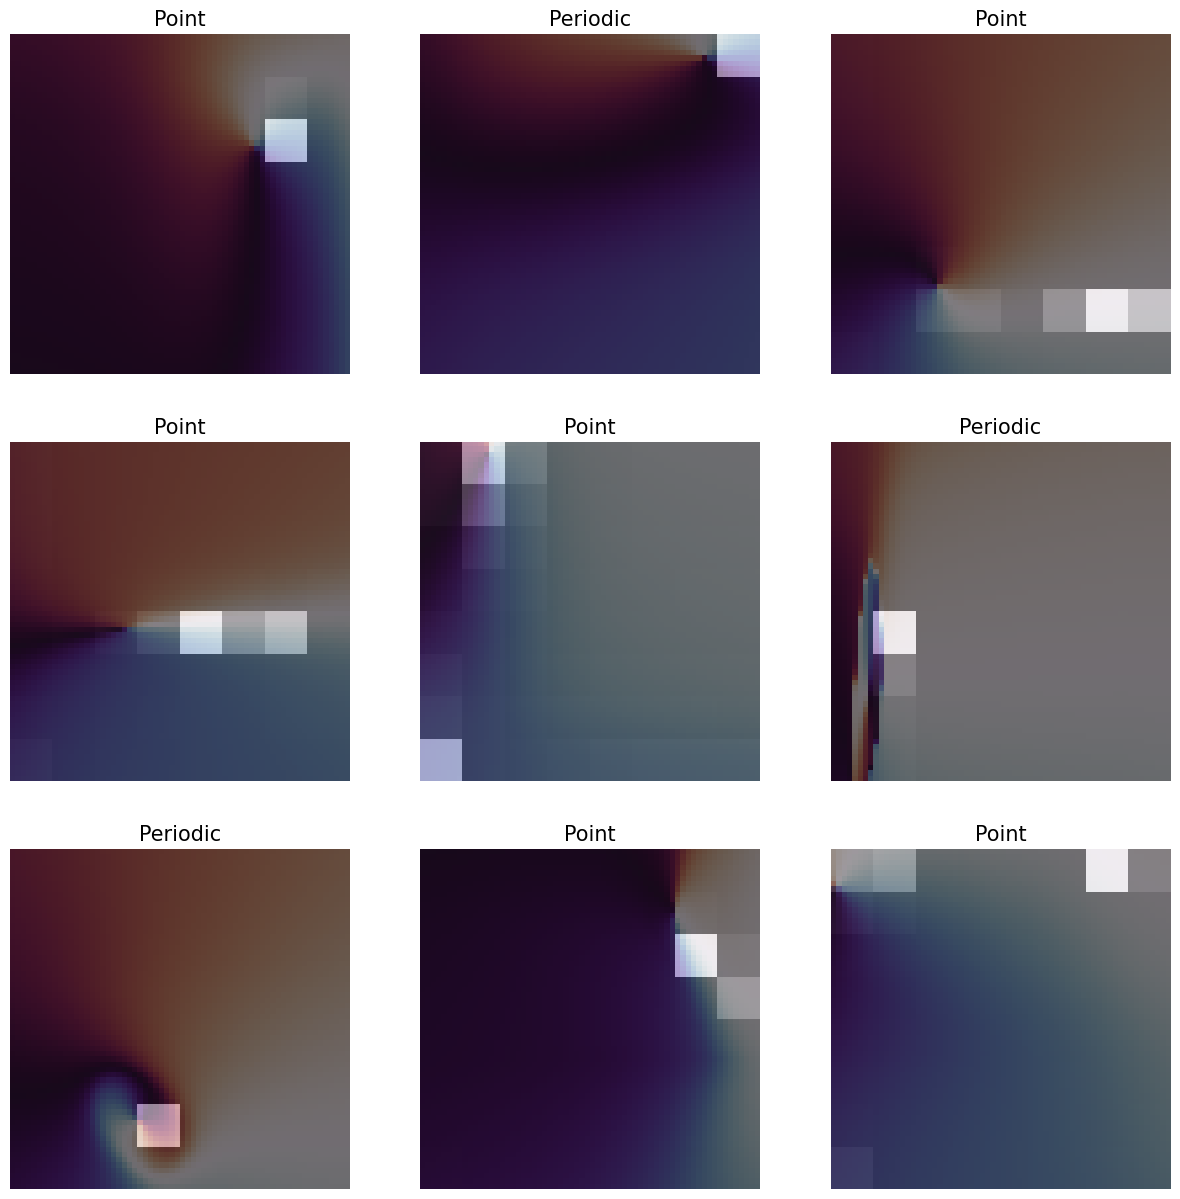

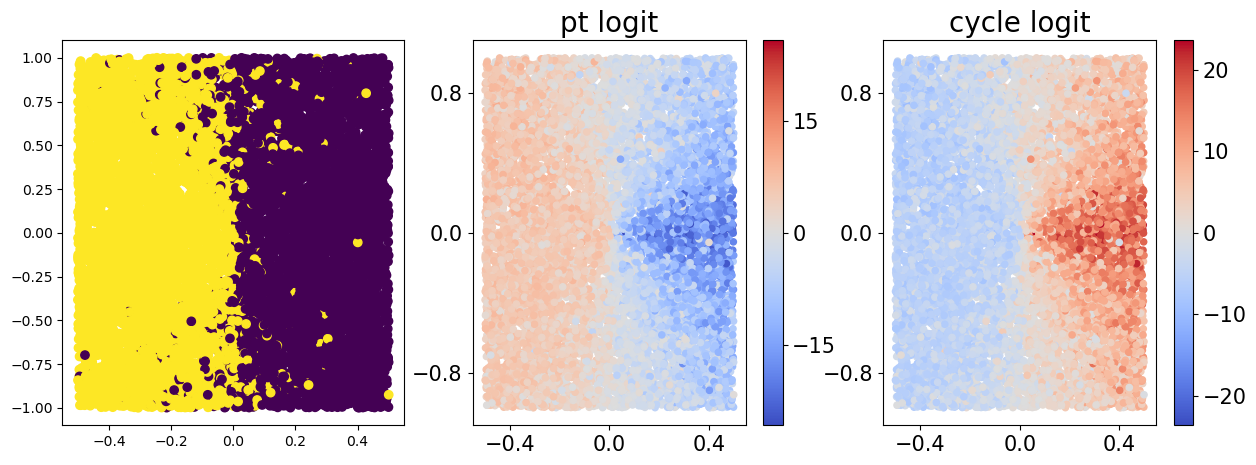

In [7]:
# visualize train results
model.plot_attention(train_dataset, n_samples=9)
correct, auc, output = eval_model(model, train_dataset)
fig, ax = plt.subplots(1,3, figsize=(15,5))
sysp = train_dataset.sysp
ax[0].scatter(sysp[:,0], sysp[:,1], c=output[:,0] > 0)
twa.utils.plot_diverge_scale(sysp[:,0], sysp[:,1], output[:,0], ax=ax[1], title='pt logit')
twa.utils.plot_diverge_scale(sysp[:,0], sysp[:,1], output[:,1], ax=ax[2], title='cycle logit')

plt.show()

# Examine test data

## Accuracy

In [8]:

results_dir = os.path.join(outdir, 'results')
# save = True; save_dir = None
exp_results_dir = os.path.join(results_dir, exp_desc)
ensure_dir(exp_results_dir)

test_data_descs = ['simple_oscillator_noaug',
                   'simple_oscillator_nsfcl',
                   'suphopf',
                   'bzreaction',
                   'selkov',
                   'lienard_poly',
                   'lienard_sigmoid',
                   'pancreas_clusters_random_bin',
]


tt = 'test'
res = []
for test_data_desc in test_data_descs:
    print(test_data_desc)
    test_data_dir = os.path.join(data_dir, test_data_desc)
    if os.path.isdir(test_data_dir):
        test_dataset = VecTopoDataset(test_data_dir,  tt=tt, to_angle=to_angle) 

        if save:
            save_dir = os.path.join(exp_results_dir, test_data_desc)
            ensure_dir(save_dir)

        correct, auc, _ = eval_model(model, test_dataset, verbose=False, save=save, save_dir=save_dir)
        res.append({'data': os.path.basename(test_data_dir),
                    'correct': correct,
                    'auc': auc})

pd.DataFrame(res)

simple_oscillator_noaug
1000
torch.Size([1000]) (1000,)
simple_oscillator_nsfcl
1100
torch.Size([1100]) (1100,)
suphopf
1000
torch.Size([1000]) (1000,)
bzreaction
1000
torch.Size([1000]) (1000,)
selkov
1000
torch.Size([1000]) (1000,)
lienard_poly
1000
torch.Size([1000]) (1000,)
lienard_sigmoid
1000
torch.Size([1000]) (1000,)
pancreas_clusters_random_bin
69
torch.Size([69]) (69,)


,data,correct,auc
0,simple_oscillator_noaug,0.971000,0.998784
1,simple_oscillator_nsfcl,0.938182,0.976165
2,suphopf,0.988000,0.999820
3,bzreaction,0.741000,0.984956
4,selkov,0.664000,0.715103
5,lienard_poly,0.959000,0.999164
6,lienard_sigmoid,0.948000,0.998934
7,pancreas_clusters_random_bin,0.898551,0.984127


1100
torch.Size([1100]) (1100,)


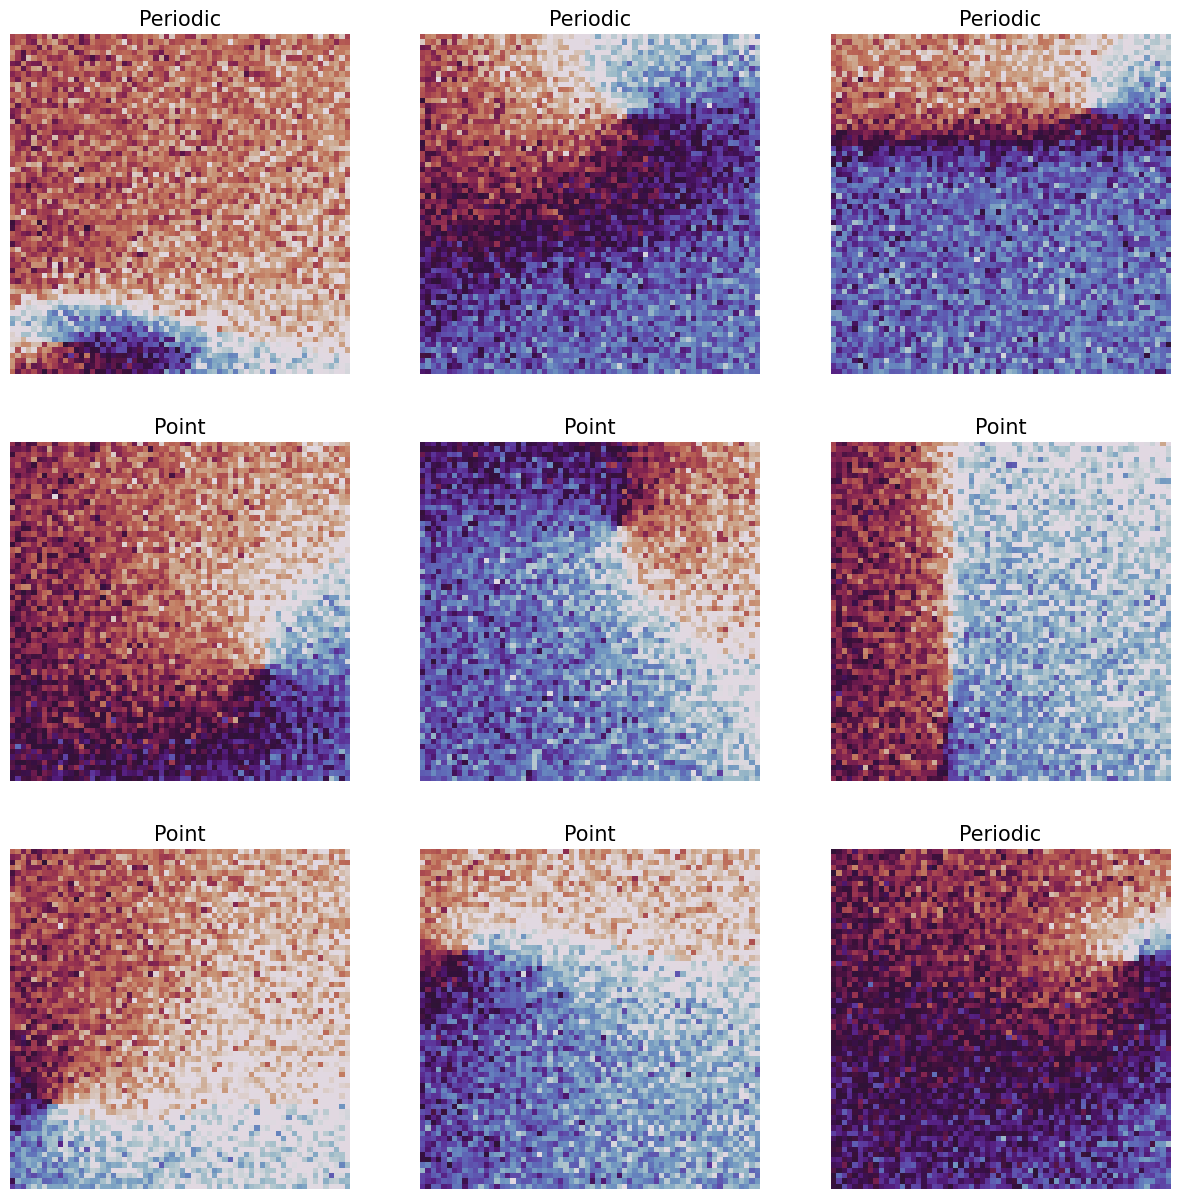

1100
torch.Size([1100]) (1100,)


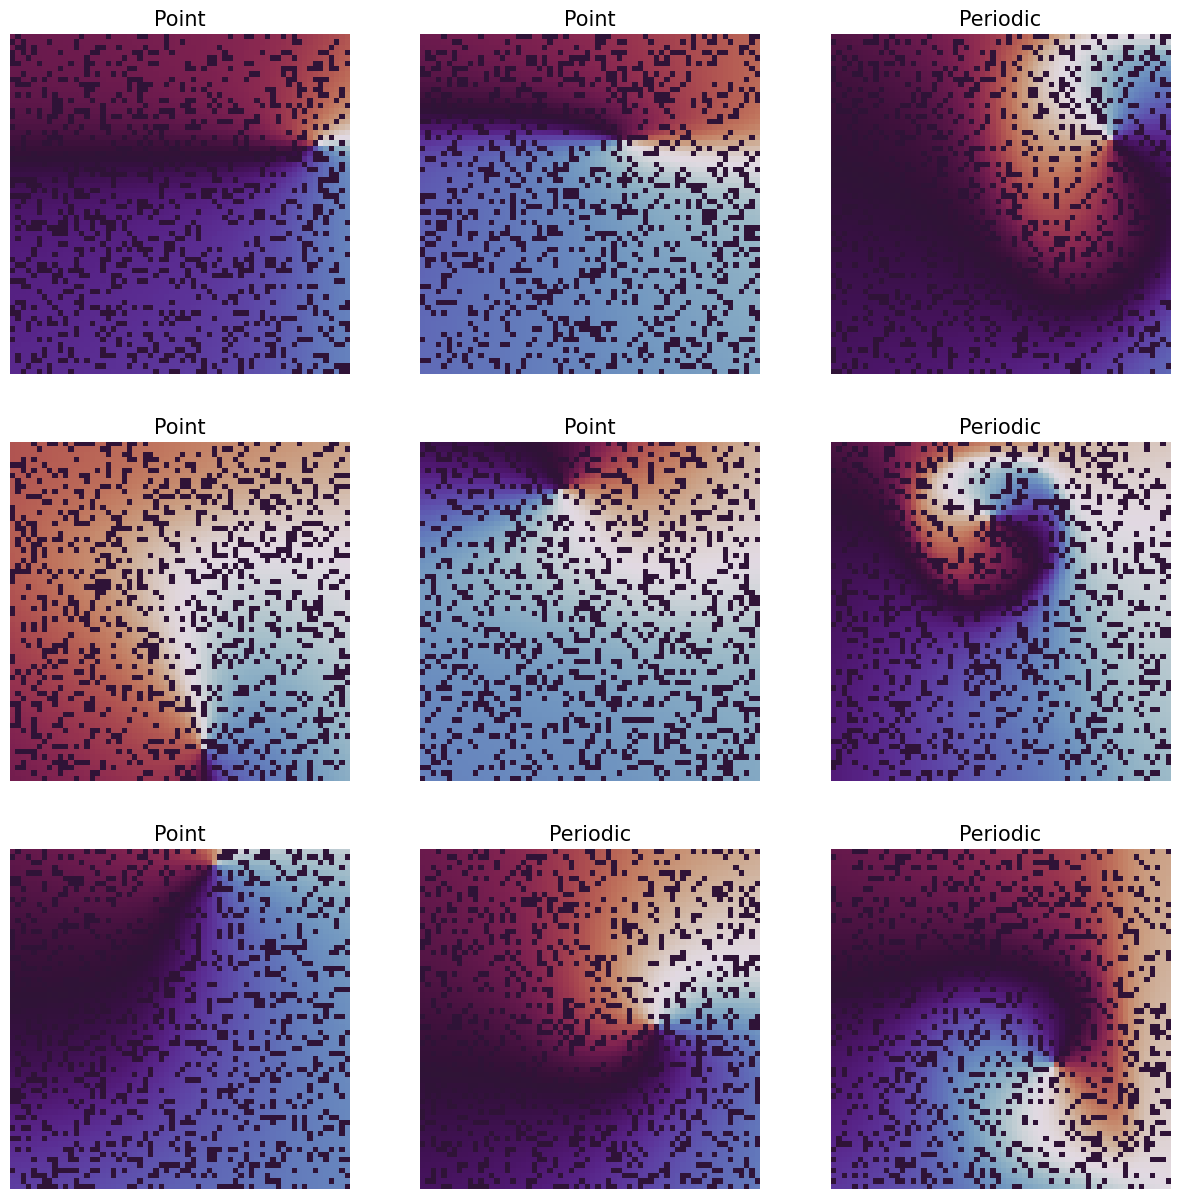

,data,correct,auc
0,simple_oscillator_noaug,0.971000,0.998784
1,simple_oscillator_nsfcl,0.938182,0.976165
2,suphopf,0.988000,0.999820
3,bzreaction,0.741000,0.984956
4,selkov,0.664000,0.715103
5,lienard_poly,0.959000,0.999164
6,lienard_sigmoid,0.948000,0.998934
7,pancreas_clusters_random_bin,0.898551,0.984127
8,simple_oscillator_nsfcl,0.740000,0.937336
9,simple_oscillator_nsfcl,0.537273,0.919217


In [10]:
# test with noise
tt = 'test'
noise = 0.5
test_data_dir = os.path.join(data_dir, train_data_desc_)
test_data_desc = train_data_desc_ + '_noise%.2f' % noise
test_dataset = VecTopoDataset(test_data_dir,  tt=tt, to_angle=to_angle, noise=noise) 

if save:
    save_dir = os.path.join(exp_results_dir, test_data_desc)
    ensure_dir(save_dir)

correct, auc, _ = eval_model(model, test_dataset, verbose=False, save=save, save_dir=save_dir)
res.append({'data': os.path.basename(test_data_dir),
            'correct': correct,
            'auc': auc})

test_dataset.plot_data()

tt = 'test'
mask_prob = 0.25
test_data_desc = train_data_desc_ + '_masked%.2f' % mask_prob
test_dataset = VecTopoDataset(test_data_dir,  tt=tt, to_angle=to_angle, mask_prob=mask_prob) 

if save:
    save_dir = os.path.join(exp_results_dir, test_data_desc)
    ensure_dir(save_dir)

correct, auc, _ = eval_model(model, test_dataset, verbose=False, save=save, save_dir=save_dir)
res.append({'data': os.path.basename(test_data_dir),
            'correct': correct,
            'auc': auc})

test_dataset.plot_data()

pd.DataFrame(res)

In [ ]:
if save:
    models_dir = os.path.join(outdir, 'models')
    exp_models_dir = os.path.join(models_dir, exp_desc)
    ensure_dir(exp_models_dir)

    torch.save(model.state_dict(), os.path.join(exp_models_dir, 'model.pt'))